# In Situ Comparison

In [320]:
import sys
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import glob
import calendar
import seaborn as sns
sys.path.append('/g/data/qz03/wp3/code/git-repo')
from utils import *

#### BARRA topography + station locations

In [7]:
barra_topo = xr.open_dataset(f'{barraR2_dir}fx/orog/v20231001/orog_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc').sel(lat=slice(domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']), lon=slice(domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max']))

In [361]:
solar_ds = xr.open_dataset('/g/data/qz03/wp3/data/obs/solar/QC_consolidated_all_stations_2024_UTC_plus_sensors_info.nc', decode_times=False)
solar_station_latlon_df = pd.DataFrame({'station': solar_ds.station.values, 'latitude': solar_ds.latitude.values, 'longitude': solar_ds.longitude.values, 'status':solar_ds.status.values})
solar_station_latlon_df

,station,latitude,longitude,status
0,Banjarbaru,-3.462250,114.840840,2
1,Batam,1.119101,104.113799,2
2,Bengkulu,-3.864850,102.312130,1
3,Bogor,-6.553260,106.742800,3
4,Bone_Bolango,0.550000,123.140000,3
5,Deli_Serdang,3.616000,98.780000,1
6,Jayapura,-2.592500,140.167800,3
7,Jembrana,-8.344400,114.827400,1
8,Kampar,0.411970,101.216930,3
9,Kupang,-10.139000,123.666900,1


In [373]:
wind_station_latlon_df = pd.read_csv('/g/data/qz03/wp3/data/obs/wind/Station_Information.csv').drop(columns=['No']).dropna()

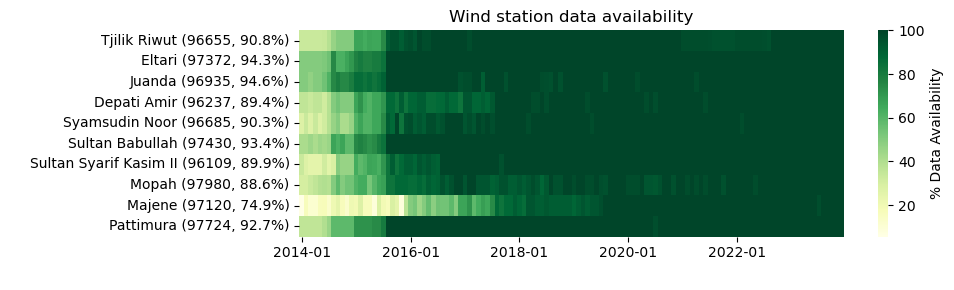

In [395]:
files = ['/g/data/qz03/wp3/data/obs/wind/'+station_csv for station_csv in os.listdir('/g/data/qz03/wp3/data/obs/wind') if 'wind' in station_csv]
dfs = {f.split('/')[-1].replace('.csv',''): pd.read_csv(f, parse_dates=['DATA TIMESTAMP']) for f in files}

months_list = []
for df in dfs.values():
    months_list.append(df['DATA TIMESTAMP'].dt.to_period('M').drop_duplicates())

all_months = pd.Index(pd.concat(months_list).drop_duplicates()).sort_values()

availability = pd.DataFrame(index=dfs.keys(), columns=all_months.astype(str))
for station, df in dfs.items():
    df['year_month'] = df['DATA TIMESTAMP'].dt.to_period('M')
    total_per_month = df.groupby('year_month').size()
    avail_per_month = df.groupby('year_month')['WIND SPEED FF'].apply(lambda x: x.notna().sum())
    pct = (avail_per_month / total_per_month).reindex(all_months, fill_value=0) * 100
    availability.loc[station] = pct.values
    
availability.index = availability.index.str[:5]
new_index = []
for station, df in dfs.items():
    total = len(df)
    available = df['WIND SPEED FF'].notna().sum()
    percent = (available / total) * 100 if total > 0 else 0
    label = f"{wind_station_latlon_df[wind_station_latlon_df['WMO ID'] == int(station[:5])]['Station Name'].values[0]} ({station[:5]}, {percent:.1f}%)"
    new_index.append(label)

availability.index = new_index
plt.figure(figsize=(10, len(dfs)*0.05 + 2.5))
sns.heatmap(availability.astype(float), cmap="YlGn", cbar_kws={'label': '% Data Availability'}, xticklabels=24)
plt.title('Wind station data availability')
plt.ylabel(' ')
plt.xlabel(' ')
plt.tight_layout()
plt.show()


In [392]:
wind_station_latlon_df

,Station Name,WMO ID,Lon,Lat,status
0,Sultan Syarif Kasim II,96109,101.44743,0.45924,1
1,Depati Amir,96237,106.13000,-2.17000,1
2,Tjilik Riwut,96655,113.95000,-2.22000,1
3,Syamsudin Noor,96685,114.75400,-3.44200,1
4,Juanda,96935,112.78330,-7.38460,1
5,Majene,97120,118.98054,-3.55074,3
6,Eltari,97372,123.67039,-10.16780,1
7,Sultan Babullah,97430,127.38000,0.83330,1
8,Pattimura,97724,128.09570,-3.71140,1
9,Mopah,97980,140.41568,-8.52019,1


In [396]:
wind_station_latlon_df['status'] = [1, 1, 2, 1, 1, 3, 1, 1, 1, 2]

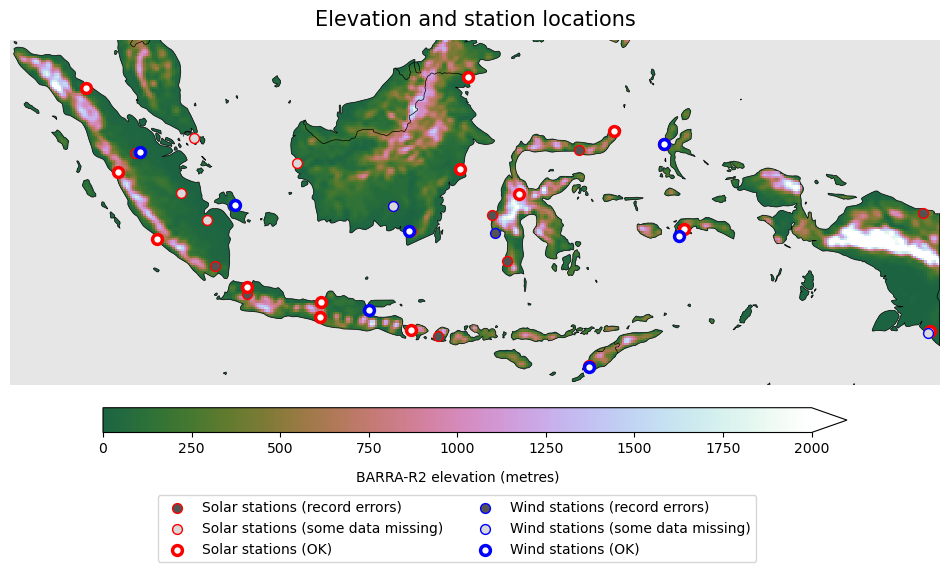

<Figure size 640x480 with 0 Axes>

In [423]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
contour = barra_topo.orog.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), vmax=2000, cmap=mcolors.LinearSegmentedColormap.from_list('trunc', plt.get_cmap('cubehelix')(np.linspace(5/17, 1, 256))), add_colorbar=False)
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', extend='max', shrink=0.8, aspect=30, pad=0.05)
cbar.set_label('BARRA-R2 elevation (metres)', labelpad=10)
ax.set_title("Elevation and station locations", size=15, pad=10)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black', zorder=10, alpha=1)
ax.add_feature(cfeature.LAND, linewidth=0.5, edgecolor='black', facecolor='none', zorder=10, alpha=1)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='#e6e6e6', alpha=1)
ax.set_frame_on(False)

ax.scatter(solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 3, 'longitude'], solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 3, 'latitude'], transform=ccrs.PlateCarree(), marker='o', color='#545353', edgecolor='red', s=50, linewidth=1, label='Solar stations (record errors)', zorder=20)
ax.scatter(solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 2, 'longitude'], solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 2, 'latitude'], transform=ccrs.PlateCarree(), marker='o', color='#d9d9d9', edgecolor='red', s=50, linewidth=1, label='Solar stations (some data missing)', zorder=20)
ax.scatter(solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 1, 'longitude'], solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 1, 'latitude'], transform=ccrs.PlateCarree(), marker='o', color='white', edgecolor='red', s=50, linewidth=2.5, label='Solar stations (OK)', zorder=20)

ax.scatter(wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 3, 'Lon'], wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 3, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='#545353', edgecolor='blue', s=50, linewidth=1, label='Wind stations (record errors)', zorder=20)
ax.scatter(wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 2, 'Lon'], wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 2, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='#d9d9d9', edgecolor='blue', s=50, linewidth=1, label='Wind stations (some data missing)', zorder=20)
ax.scatter(wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 1, 'Lon'], wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 1, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='white', edgecolor='blue', s=50, linewidth=2.5, label='Wind stations (OK)', zorder=20)

ax.legend(ncol=2, bbox_to_anchor=(0.81, -0.3))
plt.show()
plt.clf()